# **Load Dataset**

In [44]:
!pip install torch torchvision

In [45]:
import torch
print(torch.__version__)


2.1.0+cu121


In [46]:
!pip install torch_geometric


In [47]:
import torch
from torch_geometric.datasets import Planetoid


# Load the CiteSeer dataset
citeseer_dataset = Planetoid(root='', name='CiteSeer')

citeseer = citeseer_dataset[0]

In [48]:

from torch_geometric.datasets import CoraFull
# Define the root directory for the dataset
root = './CoraFull'

# Initialize the CoraFull dataset
CoraFull_dataset = CoraFull(root)

# Download and process the dataset if not already done
CoraFull_dataset.download()
CoraFull_dataset.process()

# Load the data
CoraFull =  CoraFull_dataset[0]



Using existing file cora.npz


# **Split dataset**

In [49]:
from torch_geometric.transforms import RandomNodeSplit

transform = RandomNodeSplit(num_train_per_class=int(CoraFull.num_nodes * 0.7), num_val=int(CoraFull.num_nodes * 0.1), num_test=int(CoraFull.num_nodes * 0.2))
CoraFull = transform(CoraFull)

In [50]:

transform = RandomNodeSplit(num_train_per_class=int(citeseer.num_nodes * 0.7), num_val=int(citeseer.num_nodes * 0.1), num_test=int(citeseer.num_nodes * 0.2))
citeseer = transform(citeseer)

# **Re-normalization Adjacency Matrix**

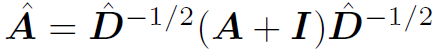

In [51]:
import scipy.sparse as sp
import numpy as np

def renormalize_adjacency(adj):

    if not isinstance(adj, sp.coo_matrix):
        adj = sp.coo_matrix(adj)

    # Add identity matrix to  adjacency matrix
    adj.setdiag(adj.diagonal() +  1)

    #  degree matrix
    row_sum = adj.sum(axis=1).A1

    #inverse square root of the degree matrix
    d_inv_sqrt = np.power(row_sum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] =  0.

    # D^{-1/2}
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

    # D^{-1/2}(A + I)D^{-1/2}
    renormalized_adjacency_matrix = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

    return renormalized_adjacency_matrix

# **DropEdge technique**

image.png

In [52]:

import torch

def calculate_A_drop(adj_matrix, deletion_rate):

    edge_indices = adj_matrix.nonzero(as_tuple=False)


    total_edges = edge_indices.size(0)


    num_edges_to_delete = int(total_edges * deletion_rate)


    permuted_indices = torch.randperm(total_edges, device=adj_matrix.device)


    indices_to_delete = edge_indices[permuted_indices[:num_edges_to_delete]]

    # Create a copy of the adjacency matrix
    modified_adj_matrix = adj_matrix.clone()

    # Delete selected edges
    modified_adj_matrix[indices_to_delete[:, 0], indices_to_delete[:, 1]] = 0

    return modified_adj_matrix





# **Prepare adjacency_matrix matrix**

In [53]:
import torch
from torch_geometric.utils import to_dense_adj

edge_index = CoraFull.edge_index

adjacency_matrix = to_dense_adj(edge_index)[0]


print(adjacency_matrix)




tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


# **Important functions**

In [54]:
def train(model, optimizer, criterion, data, adjacency_matrix):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, adjacency_matrix)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out = model(data.x, adjacency_matrix)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()

def test(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out = model(data.x, adjacency_matrix)
        _, pred = torch.max(out, dim=1)
        correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / data.test_mask.sum().item()
    return acc


# **Two layer GCN (With drop edge)**

In [55]:
import torch.nn as nn
import torch.nn.functional as F
import math

class GCNLayer_with_drop_edge(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.0):
        super(GCNLayer_with_drop_edge, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()
        self.dropout = nn.Dropout(p=dropout)

    def reset_parameters(self):
        stdv =   1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, input, adjacency_matrix):
        # Renormalize the adjacency matrix
        adjacency_matrix = renormalize_adjacency(adjacency_matrix.numpy())

        # Convert the renormalized adjacency matrix back to a PyTorch tensor
        adjacency_matrix = torch.tensor(adjacency_matrix.todense(), dtype=torch.float32)

        support = torch.mm(input, self.weight)
        output = torch.spmm(adjacency_matrix, support)
        if self.training:
            output = self.dropout(output)
        return output




In [58]:
class TwoLayerGCN_with_drop_edge(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        super(TwoLayerGCN_with_drop_edge, self).__init__()
        self.layer1 = GCNLayer_with_drop_edge(in_features, hidden_features, dropout)
        self.layer2 = GCNLayer_with_drop_edge(hidden_features, out_features, dropout)

    def forward(self, input, adjacency_matrix):
        A_drop = calculate_A_drop(adjacency_matrix , 0.4)
        x = self.layer1(input, A_drop)
        x = F.relu(x)
        A_drop = calculate_A_drop(adjacency_matrix , 0.4)
        x = self.layer2(x, A_drop) #layer-wise A_drop
        return x


## **Evaluation on corafull**

In [59]:
import torch.optim as optim
torch.manual_seed(1)

model = TwoLayerGCN_with_drop_edge(in_features =CoraFull.num_node_features, hidden_features = 64 , out_features = CoraFull_dataset.num_classes ,dropout= 0.5)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5
min_delta = 0.001
patience_counter = 0
best_loss = float('inf')

# Train the best model
for epoch in range(200):
    A_drop = calculate_A_drop(adjacency_matrix , 0.4)
    train_loss = train(model, optimizer, criterion, CoraFull , A_drop)
    val_loss = validate(model, criterion, CoraFull , adjacency_matrix)

    # Check for improvement in validation loss
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0 # Reset counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch} \n')
            break


    print(f' Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} ')

# Evaluate the model on the test data
test_accuracy = test(model, criterion, CoraFull , adjacency_matrix)
print(f'Test Accuracy(two layer) on CoraFull dataset: {test_accuracy:.4f}')

 Epoch: 0, Train Loss: 4.2880, Validation Loss: 4.1505 
 Epoch: 1, Train Loss: 4.1464, Validation Loss: 4.0282 
 Epoch: 2, Train Loss: 4.0283, Validation Loss: 3.8591 
 Epoch: 3, Train Loss: 3.9452, Validation Loss: 3.7154 
 Epoch: 4, Train Loss: 3.8165, Validation Loss: 3.5972 
 Epoch: 5, Train Loss: 3.6931, Validation Loss: 3.4866 
 Epoch: 6, Train Loss: 3.5960, Validation Loss: 3.3665 
 Epoch: 7, Train Loss: 3.4906, Validation Loss: 3.2276 
 Epoch: 8, Train Loss: 3.3965, Validation Loss: 3.0599 
 Epoch: 9, Train Loss: 3.2914, Validation Loss: 2.9165 
 Epoch: 10, Train Loss: 3.2118, Validation Loss: 2.8169 
 Epoch: 11, Train Loss: 3.1402, Validation Loss: 2.7024 
 Epoch: 12, Train Loss: 3.0833, Validation Loss: 2.5939 
 Epoch: 13, Train Loss: 3.0282, Validation Loss: 2.5041 
 Epoch: 14, Train Loss: 2.9795, Validation Loss: 2.4136 
 Epoch: 15, Train Loss: 2.9663, Validation Loss: 2.3332 
 Epoch: 16, Train Loss: 2.9007, Validation Loss: 2.2671 
 Epoch: 17, Train Loss: 2.8795, Validatio

## **Evaluation on citeseer**

In [60]:

edge_index = citeseer.edge_index


adjacency_matrix = to_dense_adj(edge_index)[0]

In [61]:
torch.manual_seed(0)

model = TwoLayerGCN_with_drop_edge(in_features =citeseer.num_node_features, hidden_features = 256 , out_features = citeseer_dataset.num_classes ,dropout= 0.0)
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5
min_delta = 0.001
patience_counter = 0
best_loss = float('inf')

# Train the best model
for epoch in range(200):
  A_drop = calculate_A_drop(adjacency_matrix , 0.4)
  train_loss = train(model, optimizer, criterion, citeseer , A_drop)
  val_loss = validate(model, criterion, citeseer , adjacency_matrix)

  # Check for improvement in validation loss
  if val_loss < best_loss - min_delta:
      best_loss = val_loss
      patience_counter = 0 # Reset counter
  else:
      patience_counter += 1
      if patience_counter >= patience:
          print(f'Early stopping at epoch {epoch} \n')
          break

  # Print the loss
  print(f' Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} ')

# Evaluate the model on the test data
test_accuracy = test(model, criterion, citeseer , adjacency_matrix)
print(f'Test Accuracy(two layer) on citeseer dataset: {test_accuracy:.4f}')



 Epoch: 0, Train Loss: 1.8260, Validation Loss: 5.4601 
 Epoch: 1, Train Loss: 4.6314, Validation Loss: 2.0882 
 Epoch: 2, Train Loss: 1.3056, Validation Loss: 1.5393 
 Epoch: 3, Train Loss: 1.0200, Validation Loss: 1.1812 
 Epoch: 4, Train Loss: 0.7557, Validation Loss: 0.9563 
 Epoch: 5, Train Loss: 0.5809, Validation Loss: 0.8980 
 Epoch: 6, Train Loss: 0.5143, Validation Loss: 0.8774 
 Epoch: 7, Train Loss: 0.4744, Validation Loss: 0.8008 
 Epoch: 8, Train Loss: 0.4402, Validation Loss: 0.8297 
 Epoch: 9, Train Loss: 0.4457, Validation Loss: 0.8362 
 Epoch: 10, Train Loss: 0.4071, Validation Loss: 0.7923 
 Epoch: 11, Train Loss: 0.3798, Validation Loss: 0.8011 
 Epoch: 12, Train Loss: 0.3440, Validation Loss: 0.7842 
 Epoch: 13, Train Loss: 0.3297, Validation Loss: 0.7774 
 Epoch: 14, Train Loss: 0.3202, Validation Loss: 0.7747 
 Epoch: 15, Train Loss: 0.3083, Validation Loss: 0.8175 
 Epoch: 16, Train Loss: 0.2906, Validation Loss: 0.7539 
 Epoch: 17, Train Loss: 0.2782, Validatio